In [124]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import pandas as pd
import matplotlib.pyplot as plt
## Use the ggplot style
plt.style.use('ggplot')

In [125]:
# My mac
data = pd.read_csv("/RawDataCSV/plotsClimateData_11092017.csv")
# My Linux desktop
#data = pd.read_csv("/RawDataCSV/idiv_share/plotsClimateData_11092017.csv")


In [126]:
data.SppN.mean()

5.1824128104220382

In [127]:
import geopandas as gpd

In [128]:
from django.contrib.gis import geos
from shapely.geometry import Point

In [129]:
data['geometry'] = data.apply(lambda z: Point(z.LON, z.LAT), axis=1)
new_data = gpd.GeoDataFrame(data)

## Let´s reproject to Alberts or something with distance

In [130]:
new_data.crs = {'init':'epsg:4326'}

### Uncomment to reproject
proj string taken from: http://spatialreference.org/

In [131]:
#new_data =  new_data.to_crs("+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs ")

## The area is very big -> 35000 points. 
We need to make a subset of this


In [132]:
# COnsider the the following subregion
section = new_data[lambda x:  (x.LON > -90) & (x.LON < -85) & (x.LAT > 30) & (x.LAT < 35) ]

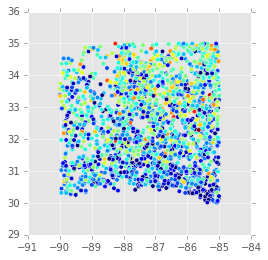

In [133]:
section.plot(column='SppN')

In [134]:
section.shape

(1841, 42)

In [135]:
section['newLon'] = section.apply(lambda c : c.geometry.x, axis=1)
section['newLat'] = section.apply(lambda c : c.geometry.y, axis=1)

/opt/conda/envs/biospytial/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/biospytial/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


# Model Fitting Using a GLM 

The general model will have the form:
$$ Biomass(x,y) = \beta_1 AET + \beta_2 Age + Z(x,y) + \epsilon $$
Where:
$\beta_1$ and $\beta_2$ are model parameters, $Z(x,y)$ is the *Spatial Autocorrelation* process and $\epsilon \sim N(0,\sigma^2)$

In [136]:
##### OLD #######
len(data.lon)
#X = data[['AET','StandAge','lon','lat']]
X = data[['SppN','lon','lat']]
#X = data[['lon','lat']]
Y = data['plotBiomass']
#Y = data[['SppN']]
## First step in spatial autocorrelation
#Y = pd.DataFrame(np.zeros(len(Y)))
## Let´s take a small sample only for the spatial autocorrelation
import numpy as np
sample_size = 2000
randindx = np.random.randint(0,X.shape[0],sample_size)
nX = X.loc[randindx]
nY = Y.loc[randindx]


## For new section

In [137]:
X = section[['newLon','newLat']]
#X = data[['lon','lat']]
Y = section['SppN']
sample_size = Y.shape[0]

In [138]:
## Let´s make a simple linear trend here.
import statsmodels as stm
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score


In [139]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X, Y)

# Make predictions using the testing se
Y_hat = regr.predict(section[['lon','lat']])

In [140]:
# MEAN SQuare error 
error = mean_squared_error(section.SppN,Y_hat)
print(error)

8.9314327416


In [141]:
r_score = r2_score(section.SppN,Y_hat)
print(r_score)

0.1016929887


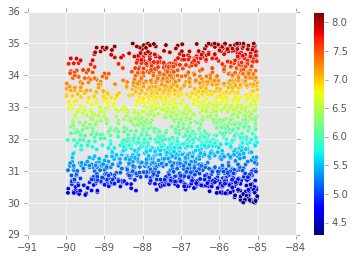

In [142]:
plt.scatter(section.lon,section.lat,c=Y_hat)
plt.colorbar()

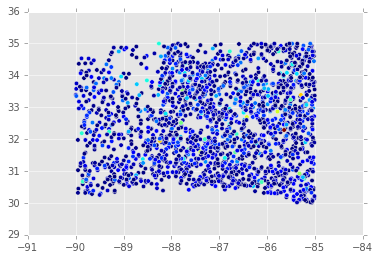

In [143]:
qr_errors = (Y - Y_hat)**2 
plt.scatter(section.lon,section.lat,c=qr_errors)

In [144]:
# Import GPFlow
import GPflow as gf
k = gf.kernels.Matern12(2, lengthscales=1, active_dims = [0,1] )

In [145]:
model = gf.gpr.GPR(section[['lon','lat']].as_matrix(),qr_errors.as_matrix().reshape(len(qr_errors),1),k)

In [146]:
%time model.optimize()

CPU times: user 4min 19s, sys: 12.7 s, total: 4min 32s
Wall time: 2min 31s


      fun: 7111.5809722157537
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.31755704e-05,   3.90132975e-06,  -4.84728610e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 37
      nit: 36
   status: 0
  success: True
        x: array([  30.78216725,   49.04668616,  130.6060237 ])

In [147]:
import numpy as np
Nn = 300
dsc = section
predicted_x = np.linspace(min(dsc.newLon),max(dsc.newLon),Nn)
predicted_y = np.linspace(min(dsc.newLat),max(dsc.newLat),Nn)
Xx, Yy = np.meshgrid(predicted_x,predicted_y)
## Fake richness
fake_sp_rich = np.ones(len(Xx.ravel()))
predicted_coordinates = np.vstack([ Xx.ravel(), Yy.ravel()]).transpose()
#predicted_coordinates = np.vstack([section.SppN, section.newLon,section.newLat]).transpose()

In [148]:
predicted_coordinates.shape

(90000, 2)

In [149]:
means,variances = model.predict_y(predicted_coordinates)

In [150]:
means.shape

(90000, 1)

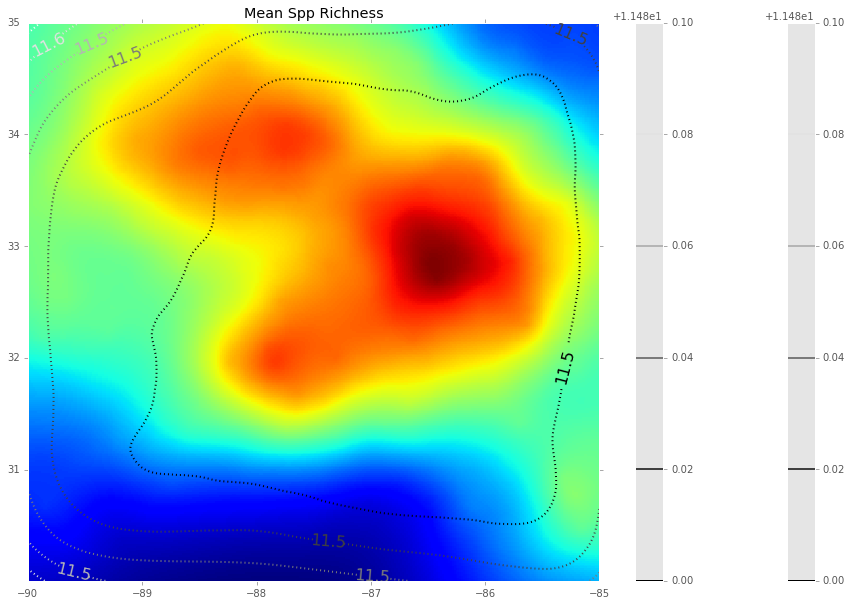

In [151]:
fig = plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='w')
plt.pcolormesh(Xx,Yy,means.reshape(Nn,Nn)) #,cmap=plt.cm.Greens)
cs = plt.contour(Xx,Yy,np.sqrt(variances).reshape(Nn,Nn),linewidths=2,cmap=plt.cm.Greys_r,linestyles='dotted')
plt.clabel(cs, fontsize=16,inline=True,fmt='%1.1f')
plt.colorbar()
#plt.scatter(dsc.newLon,dsc.newLat,c=dsc.SppN,edgecolors='')
plt.title("Mean Spp Richness")
plt.colorbar()



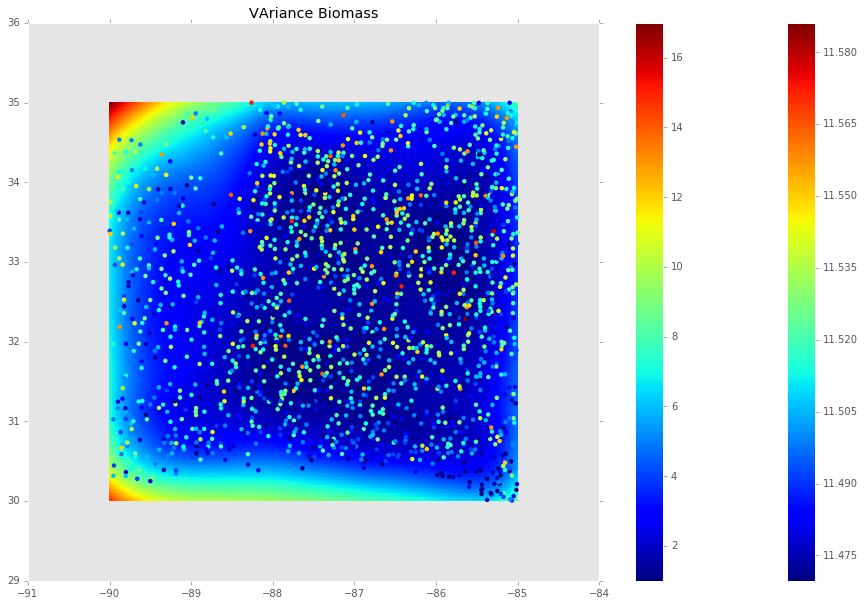

In [152]:
fig = plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='w')
#plt.pcolor(Xx,Yy,np.sqrt(variances.reshape(Nn,Nn))) #,cmap=plt.cm.Greens)
plt.pcolormesh(Xx,Yy,np.sqrt(variances.reshape(Nn,Nn)))
plt.colorbar()
plt.scatter(dsc.newLon,dsc.newLat,c=dsc.SppN,edgecolors='')
plt.title("VAriance Biomass")
plt.colorbar()

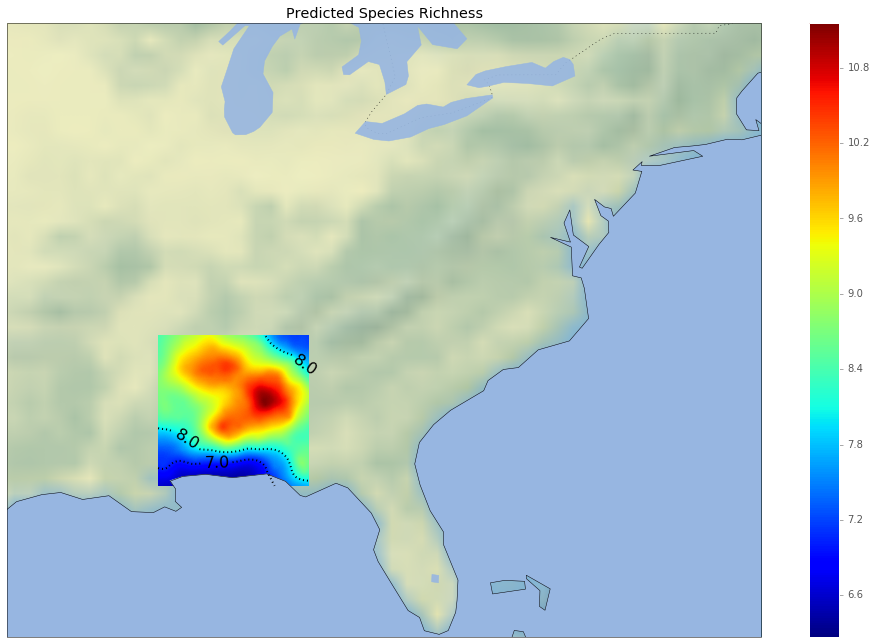

In [153]:
import cartopy
plt.figure(figsize=(17,11))

proj = cartopy.crs.PlateCarree()
ax = plt.subplot(111, projection=proj)


ax = plt.axes(projection=proj)
#algo = new_data.plot(column='SppN',ax=ax,cmap=colormap,edgecolors='')


#ax.set_extent([-93, -70, 30, 50])
#ax.set_extent([-100, -60, 20, 50])
ax.set_extent([-95, -70, 25, 45])

#ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.9)
ax.stock_img()
#ax.add_geometries(new_data.geometry,crs=cartopy.crs.PlateCarree())
#ax.add_feature(cartopy.feature.RIVERS)
mm = ax.pcolormesh(Xx,Yy,means.reshape(Nn,Nn),transform=proj )
#cs = plt.contour(Xx,Yy,np.sqrt(variances).reshape(Nn,Nn),linewidths=2,cmap=plt.cm.Greys_r,linestyles='dotted')
cs = plt.contour(Xx,Yy,means.reshape(Nn,Nn),linewidths=2,colors='k',linestyles='dotted',levels=[4.0,5.0,6.0,7.0,8.0])
plt.clabel(cs, fontsize=16,inline=True,fmt='%1.1f')
#ax.scatter(new_data.lon,new_data.lat,c=new_data.error,edgecolors='',transform=proj,cmap=plt.cm.Greys,alpha=0.2)
plt.colorbar(mm)
plt.title("Predicted Species Richness")


#(x.LON > -90) & (x.LON < -80) & (x.LAT > 40) & (x.LAT < 50)

## Model Analysis


In [154]:
model.kern

Name,values,prior,constraint
kern.lengthscales,[ 30.78216825],None,+ve
kern.variance,[ 49.04668716],None,+ve


In [155]:
model.likelihood

Name,values,prior,constraint
likelihood.variance,[ 130.6060247],None,+ve


## Let's calculate the residuals

In [156]:
X_ = section[['LON','LAT']]
%time resid_hat, resid_hat_variance = model.predict_y(X_)

CPU times: user 1.22 s, sys: 140 ms, total: 1.36 s
Wall time: 1.25 s


In [158]:
resid_hat.shape

(1841, 1)

In [159]:
qr_errors = qr_errors.values.reshape(len(qr_errors),1)

In [160]:
#new_data= new_data.assign(error=lambda y : (y.SppN - y.pred_y)**2 )
sqr_error_errors = pd.DataFrame((qr_errors - resid_hat)**2)

In [161]:
print(sqr_error_errors[0].mean())
print(sqr_error_errors[0].std())

129.423882449
449.938616815


In [191]:
#

0        12
1         3
2        15
3         5
4        13
5         6
6        10
7         4
8         3
9         6
10        1
11        8
12        8
13        9
14        1
15        6
16        4
17        3
18        8
19        2
20        2
21        8
22        1
23        5
24        1
25        6
26        7
27        6
28        6
29        6
         ..
17045     7
17046     7
17047     8
17048     7
17049     4
17050     2
17051     6
17064     7
17065    12
17066     1
17067     8
17068     6
17069     6
17070    10
17071     8
17072     7
17073    11
17074     5
17075    11
17076     7
17077     7
17078     7
28425     7
28426     5
28464     3
28466     8
28500    15
28663     3
28669     8
28672     6
Name: SppN, dtype: int64

In [183]:
true_error

0    [[27.3755518619, 201.52751954, 5.29125409885, ...
dtype: object

In [162]:
sqr_error_errors.mean()

0    129.423882
dtype: float64

In [130]:
k.ARD?